<hr style="border:1px solid black"> </hr>

<figure>
  <IMG SRC="Images/NTNU_logo.png" WIDTH=200 ALIGN="right">
</figure>

# Solo project
Notebook developed by Erik Storrønning

In the course TVM 4174: Hydroinformatics for Smart Water Systems, the students were tasked with an open project related to hydroinformatics. The project topics were designed and chosen by the students themselfs. 

## Project topic

The chosen topic was calibration of roughness coefficients with Hazen Williams formula  utilizing Differential Evolution algorithms. Including roughness coefficient estimation the notebook also plots and evaluates pipe age for any cast iron pipe. Both roughness coefficient and pipe age calculations was done with following pipe dimensions, diameter (D) = 0.250m and lenght (L) = 50m.

<hr style="border:0.2px solid black"> </hr>



## Theory
<hr style="border:0.2px solid black"> </hr>

### Hazen williams and roughness coefficient

The Hazen–Williams equation is an empirical formula that relate flow of water in a pipe with physical properties of the pipe and the pressure drop caused by friction. The equation is utilized in design of water pipe systems such as fire sprinkler systems, water supply networks, and irrigation systems.

Advantages og the Hazen Williams equation is that the roughness coeffisient, C is nor dependent on the Reynolds number, temperature or viscosity. This however restricts the formula to room temperatures and conventional velocities.([hazen-williams](https://en.wikipedia.org/wiki/Hazen%E2%80%93Williams_equation))

Hazen-Williams head loss formula:

$ \Delta h \ = \ \frac{10.67 \cdot Q^{1.852}}{C^{1.852} d^{4.8704}} \cdot L $

<hr style="border:0.2px solid black"> </hr>


### Sum of Squared Errors 
Sum of Squared Errors will be used as fitness function to minimize the difference between measured headlossses $p_{i}$ and simulated headlosses $\hat{p}_i$ for different headloss measurements in the system, $N_S$:

$$ f(\mathbf{x}) \ =  \text{SSE}(\mathbf{x}) \ = \ \sum_{i=1}^{N_S}\left( p_{i} - \hat{p}_{i} \right)^2 \qquad \rightarrow \qquad \min_{\mathbf{x} \in \mathcal{R}} f(\mathbf{x})$$

The fitness function will be combined with the optimization algorithm, Differential Evolution from Scipy Optimize to estimate the best roughness coefficient. 

<hr style="border:0.2px solid black"> </hr>

### Differential Evolution

Differential evolution is a evolutionary algorithm, meaning it combines principles from biology and implements them over calculus. The algorithm is an optimization method which can tacle a larger variety of problems due to its simplicty. To put things simply, with an initial population it will evalute the problem with a criterion, in our case the fitting function SSE, and look for combinations of desired variables to optimize in accordance with the SSE. The algorithm will iterate through different combinations until it can no longer find a better result of variables. ([differential evolution](https://www.frontiersin.org/articles/10.3389/fbuil.2020.00102/full)) See figure for illustrative explanation. 



<figure>
  <IMG SRC="Images/DE.jpg" WIDTH=400 ALIGN="center">
</figure>


### Prerequisites of the notebook
The following notebook utlizises a measurement file with two columns: Q in (L/S) and headloss (m). If it is desirable to run simulations with other measurements, feel free to upload and change measurement file. The Hazen Williams formula is also set for pipe diameter of 250mm and pipe length of 50m, if any other specifications are desirable they need to be changed manually. 




In [9]:
#Import necessary packages and reading of given measurements.

from scipy import optimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data=pd.read_excel('measurements.xlsx',index_col=0)

In [10]:
#Isolate measured run off values and convert l/s to m^3/s
Q=data['Q']/1000



# Isolate measured headloss values
dH_measured=data['delta_h']  

In [17]:
# Simulation of headloss values, using Hazen-Williams
def hazen_w(Q, C,d,L):
    dH_simulated = -(10.67 * Q ** 1.852) / (C ** 1.852 * d ** 4.8704) * L
    return dH_simulated


# Fitness function, SSE with the measured and simulated headloss values as parameters
def calculate_SSE(dH_simulated, dH_measured):
    return np.sum((dH_measured - dH_simulated)**2)

# Simple anonymous function with parameter C. Different C-values are feeded and the function simulates headlosses using 
# the hazen-w formula mentioned above. These values are compared with measured headloss values with the SSE formula above. 
#de_simulated_coeff=lambda C: calculate_SSE(hazen_w(Q,C,d=0.25,L=50),dH_measured)

def de_simulated_coeff(C):
    SSE=calculate_SSE(hazen_w(Q,C,d=0.25,L=50),dH_measured)
    return SSE

#With a set boundary of (0,200) we use the differential evolution function to find the roughness value with the lowest SSE
lowest_sse_result = optimize.differential_evolution(de_simulated_coeff, [(0.0,200)])
print('Minimum SSE achieved was:',lowest_sse_result.fun, 'with a roughness coefficient:', lowest_sse_result.x ,
      ', this took',lowest_sse_result.nit, 'iterations.')

#Just some extra details if the user is interested
full_report=input('Do you want to see full report from simulation, yes or no \n')

if full_report=='yes':
    print('\n', lowest_sse_result)
else:
    print('\nFull report was not printed')
    

Minimum SSE achieved was: 0.19671214972141243 with a roughness coefficient: [84.88261862] , this took 8 iterations.
Do you want to see full report from simulation, yes or no 
yes

      fun: 0.19671214972141243
     jac: array([-3.87468079e-06])
 message: 'Optimization terminated successfully.'
    nfev: 141
     nit: 8
 success: True
       x: array([84.88261862])


The following graph illustrates the goodnes of fit for the given roughness value, compared to measured values


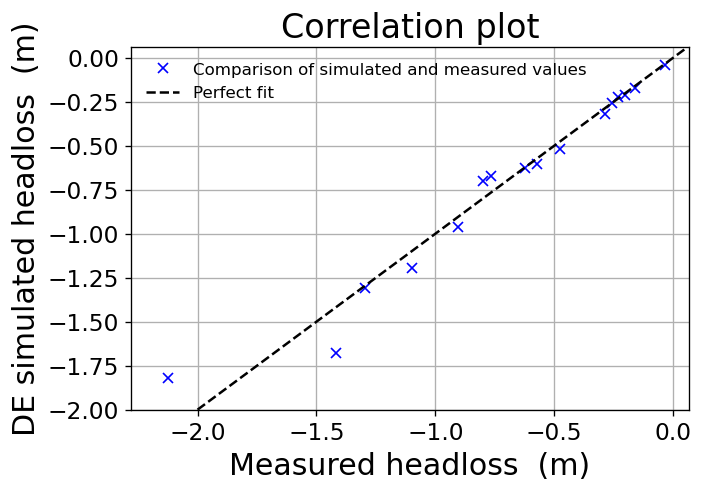

In [12]:
#Plotting of our simulated and measured values
plt.rcParams['figure.dpi'] = 120
fig, ax = plt.subplots()


#We want to only plot the best scenario, so we run Hazen-w with the given roughness value of 84.883
optimal_result = hazen_w(Q,lowest_sse_result.x,d=0.25,L=50)
x = dH_measured
y = optimal_result
ax.plot(x, y, marker='x', linestyle='None', label='Comparison of simulated and measured values',color='blue')

#It is also desirable to compare our findinds to a perfect fit, which would mean identical values for simulated and measured
ax.axline([0, 0], [1, 1], color='k', linestyle='--', label='Perfect fit')
ax.legend(frameon=False)
ax.grid(True)
ax.set_xlim(None, dH_measured.max()+0.1)
ax.set_ylim(-2.0, optimal_result.max()+0.1);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_xlabel('Measured headloss  (m)', fontsize=18)
ax.set_ylabel('DE simulated headloss  (m)', fontsize=18)
ax.set_title('Correlation plot', fontsize=20);

print('The following graph illustrates the goodnes of fit for the given roughness value, compared to measured values')

In [13]:
#Read in roughness values for different pipe materials
Cdata=pd.read_csv('C_factors.csv', sep=';',index_col=0)

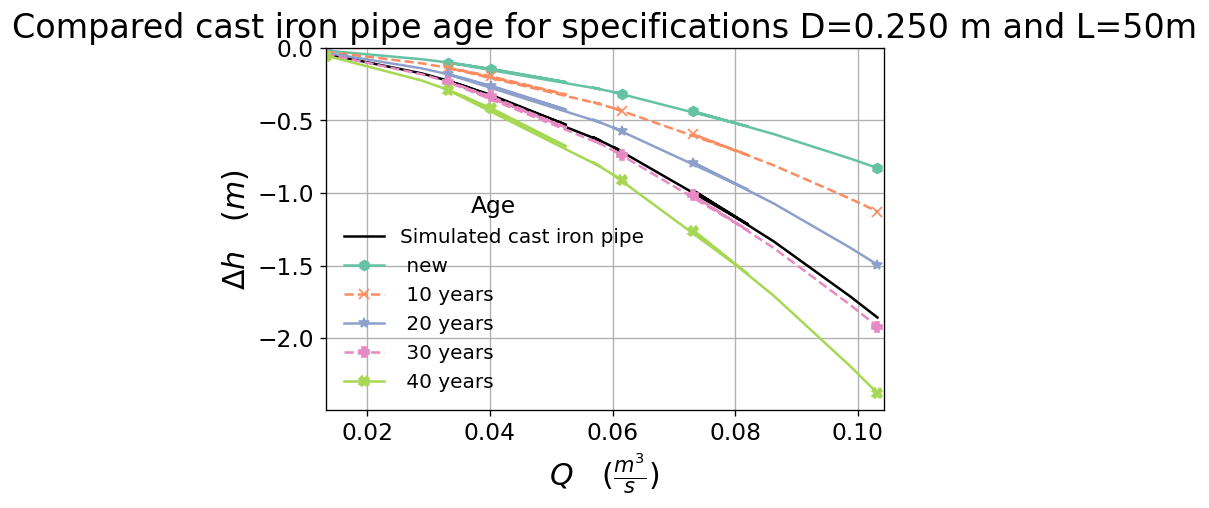

Estimated pipe age for pipe of interest is illustrated in the figure above.


In [14]:
#The notebook only estimates pipe age for cast iron pipes, average roughness values will also be used
cast_irons=[x.startswith('Cast') for x in Cdata.index]
pipedata=Cdata[cast_irons]
pipedata=pipedata.mean(axis=1)

#Let's differentiate materials with colors, markers and styles
colors = sns.color_palette('Set2', len(pipedata))
markers = 'hx*PX'
styles = ['-', '--']

#Simulated values for our pipe of interest
simulated=hazen_w(Q,int(lowest_sse_result.x),d=0.250,L=50)
plt.plot(Q,simulated, label='Simulated cast iron pipe', color= 'black')

#Iterations through the different cast iron ages
for x, (name, c_value) in enumerate(pipedata.iteritems()):
    dH = hazen_w(Q, C=c_value, d=0.250, L=50)
    plt.plot(Q, dH, label=name.replace('Cast iron', ''), marker=markers[x], markevery=3, color=colors[x], linestyle=styles[x % 2])

#Just plot specifications
plt.legend(loc=3, fontsize=12, frameon=False, title='Age', title_fontsize=14)
plt.title('Compared cast iron pipe age for specifications D=0.250 m and L=50m', fontsize=20)
plt.xlim((Q.min(),Q.max()+0.001 ))
plt.ylim((None, 0))
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$Q \quad (\frac{m^3}{s}) $', fontsize=18)
plt.ylabel(r'$\Delta h \quad (m) $', fontsize=18)
plt.show()

print('Estimated pipe age for pipe of interest is illustrated in the figure above.')